# Nowcasting Global Surface Irradiance and Cloud Optical Depth with 3D U-Net

This notebook develops and tests a 3D U-Net model for nowcasting Cloud Optical Depth and Surface Irradiance over the Darwin region using Himawari-8 satellite data.
The model takes 7 past timesteps (every 10 minutes) as input and predicts 3 future lead times at +1 h, +2 h, and +3 h.

# This notebook is all about inference and evaluation

The model was trained using 50k samples

In [47]:
import warnings
warnings.filterwarnings("ignore")

In [48]:
import datetime
from datetime import timedelta

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

In [49]:
import pyearthtools.data as petdata
from pyearthtools.data.time import TimeResolution, Petdt

import pyearthtools.pipeline as petpipe
from pyearthtools.pipeline.operation import Operation

import pyearthtools.data.indexes._indexes as idx
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=idx.IndexWarning, message="Data requested at a higher resolution")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="NetCDF: HDF error")

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import IterableDataset

import pytorch_lightning as pl
import torchmetrics.image

In [51]:
torch.manual_seed(42)                                      
torch.set_float32_matmul_precision('medium')             
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [52]:
import site_archive_jasmin as saj                  
print(saj.ROOT_DIRECTORIES)

{'ERA5lowres': '/gws/ssde/j25a/mmh_storage/theme3/weatherbench/5.625deg/', 'MOGLOBAL': '/gws/ssde/j25a/mmh_storage/theme3/mo_pet_site_archive/mo_global/', 'MOUKV': '/gws/ssde/j25a/mmh_storage/theme3/mo_pet_site_archive/mo_ukv/', 'Himawari': '/gws/ssde/j25a/mmh_storage/theme3/rv74_himawari', 'HimawariChannels': '/gws/ssde/j25a/mmh_storage/theme3/ra22_himawari', 'Rainfields3': '/gws/ssde/j25a/mmh_storage/theme3/rq0_rainfields_prcp_crate'}


In [53]:
from functools import lru_cache

# Loading data and choosing variables

In [54]:
vars_to_load = ["surface_global_irradiance", "cloud_optical_depth"]
himawari = petdata.archive.Himawari(vars_to_load)

In [55]:
himawari

Himawari
	Description                    Himawari 8/9 satellite data
		 Range                          '2019-current'
		 Resolution                     '10 minutes'


	Initialisation                 
		 data_interval                  (10, 'm')
		 file_regex                     '*{date_info}*{time_info}*.nc'
		 variables                      ['surface_global_irradiance', 'cloud_optical_depth']
	Transforms                     
		 StandardCoordinateNames        {'latitude': "['lat', 'Latitude', 'yt_ocean', 'yt']", 'longitude': "['lon', 'Longitude', 'xt_ocean', 'xt']", 'replacement_dictionary': 'None', 'time': "['Time']"}
		 Trim                           {'__args': '()', 'variables': "['surface_global_irradiance', 'cloud_optical_depth']"}

# Create a PET Pipeline to prepare dataset for training

## This function is to make sure to use new indices for merging

In [56]:
def proper_temporal_merge(samples):
    valid = []
    for i, s in enumerate(samples):
        if s is not None:
            s = s.copy(deep=True)
            s = s.assign_coords(time=[s.time.values[0] + np.timedelta64(i*10, "m")])
            valid.append(s)
    return xr.concat(valid, dim="time", combine_attrs="override")

## Per-Channel Scaling

In [57]:
class PerChannelScale(Operation):
    def __init__(self, scale_dict):
        """
        scale_dict: dict mapping variable name to scaling factor
        e.g. {"surface_global_irradiance": 1200, "cloud_optical_depth": 60}
        """
        super().__init__(operation="apply")
        self.scale_dict = scale_dict

    def apply_func(self, sample):
        # If TemporalRetrieval returns a tuple, process each element recursively
        if isinstance(sample, tuple):
            return tuple(self.apply_func(s) for s in sample)

        # Normal case: single xarray.Dataset
        ds = sample.copy()
        for var, factor in self.scale_dict.items():
            if var in ds:
                ds[var] = ds[var] / float(factor)
        return ds

## PET data pipeline

In [58]:
scales = {
    "surface_global_irradiance": 1200,   # W/m²
    "cloud_optical_depth": 60            # unitless
}

In [59]:

@lru_cache(maxsize=16)
def make_pipeline(start_time, end_time, region=(-15.5, -8, 130, 135.5)):

    himawari.data_resolution = TimeResolution("minute")
    himawari.data_resolution.value = 10
    
    return petpipe.Pipeline(
        himawari,
        petpipe.operations.xarray.Sort(order=["time", "latitude", "longitude"]),
        petpipe.operations.xarray.AlignDataVariableDimensionsToDatasetCoords(),

        # Temporal window: 7 past frames (t−6 to t₀, every 10 min) and 3 future frames (+1h, +2h, +3h)
        petpipe.modifications.TemporalWindow(
            prior_indexes=[-6, -5, -4, -3, -2, -1, 0],
            posterior_indexes=[6, 12, 18],
            timedelta=timedelta(minutes=10),
            merge_method=proper_temporal_merge
        ),

        petdata.transform.region.Bounding(*region),
        PerChannelScale(scales),
        petpipe.operations.xarray.conversion.ToNumpy(),
        petpipe.operations.numpy.reshape.Rearrange("t c h w -> c t h w"),

        iterator=petpipe.iterators.DateRange(
            start_time,
            end_time,
            interval="10 minutes"
        ),

        exceptions_to_ignore=(petdata.exceptions.DataNotFoundError, ValueError),
    )


# Define model

## Base model

In [60]:
class UNet3D(nn.Module):
    def __init__(self, in_channels=2, out_channels=2, base_filters=32, use_lag=False):
        super().__init__()
        self.use_lag = use_lag

        # ---- Encoder ----
        self.enc1 = self._block(in_channels + (1 if use_lag else 0), base_filters)
        self.enc2 = self._block(base_filters, base_filters * 2)
        self.enc3 = self._block(base_filters * 2, base_filters * 4)
        self.pool = nn.MaxPool3d((1, 2, 2))  # halve spatial dims only

        # ---- Bottleneck ----
        self.bottleneck = self._block(base_filters * 4, base_filters * 8)

        # ---- Decoder ----
        self.up3 = nn.ConvTranspose3d(base_filters * 8, base_filters * 4,
                                      kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.dec3 = self._block(base_filters * 8, base_filters * 4)
        self.up2 = nn.ConvTranspose3d(base_filters * 4, base_filters * 2,
                                      kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.dec2 = self._block(base_filters * 4, base_filters * 2)
        self.up1 = nn.ConvTranspose3d(base_filters * 2, base_filters,
                                      kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.dec1 = self._block(base_filters * 2, base_filters)

        # ---- Temporal projection ----
        self.temporal_head = nn.Sequential(
            nn.Conv3d(base_filters, base_filters, (3, 1, 1), padding=(1, 0, 0)),
            nn.ReLU(inplace=True),
            nn.Conv3d(base_filters, out_channels, (3, 1, 1), padding=(1, 0, 0))
        )

    def _block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv3d(in_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm3d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm3d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, lag=None):
        # Input: (B, 2, T, 276, 276)
        if self.use_lag and lag is not None:
            x = torch.cat([x, lag], dim=1)

        # Downscale to power-of-two size for better performance
        x256 = F.interpolate(x, size=(x.shape[2], 256, 256),
                             mode="trilinear", align_corners=False)

        # Encoder 
        e1 = self.enc1(x256)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        b  = self.bottleneck(self.pool(e3))

        # Decoder
        d3 = self.dec3(torch.cat([self.up3(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        # Temporal head 
        out256 = self.temporal_head(d1)        # (B, 2, T, 256, 256)
        out256 = out256[:, :, -3:, :, :]       # keep last 3 future frames

        # Updample back to original 276×276
        out = F.interpolate(out256, size=(out256.shape[2], 276, 276),
                            mode="trilinear", align_corners=False)

        return out

## Custom loss function

The pooled MSE loss compares the **smoothed prediction** $\tilde{\hat{y}}$ and **smoothed target** $\tilde{y}$,  
where both are averaged over a $k \times k$ neighbourhood before computing their mean-squared difference.

$$
\mathcal{L}_{\text{pooled-MSE}}
=
\frac{1}{H\,W}
\sum_{i=1}^{H}
\sum_{j=1}^{W}
\Big(
\tilde{\hat{y}}(i, j)
-
\tilde{y}(i, j)
\Big)^{2}.
$$

This loss encourages the model to match the **spatial structures** of the target field rather than only exact pixel values.

In [61]:
class PooledMSELoss(nn.Module):
    def __init__(self, pool=9):
        super().__init__()
        self.pool = pool

    def forward(self, pred, target):
        # pred, target: (B, C, T, H, W)
        B, C, T, H, W = pred.shape

        # depthwise kernel (one per channel)
        kernel = torch.ones((C, 1, 1, self.pool, self.pool), device=pred.device) / (self.pool ** 2)

        # smooth each channel independently
        pred_smooth = F.conv3d(
            pred, kernel, padding=(0, self.pool // 2, self.pool // 2), groups=C
        )
        target_smooth = F.conv3d(
            target, kernel, padding=(0, self.pool // 2, self.pool // 2), groups=C
        )

        return F.mse_loss(pred_smooth, target_smooth)

## PyTorch lightning wrapper of the model

This class wraps the 3D U-Net model in a PyTorch Lightning module, handling the full training and validation workflow.  
It defines the forward pass, computes the loss, and logs training and validation metrics automatically.  

In [62]:
class NowcastLitModule(pl.LightningModule):
    def __init__(self, lr=1e-4):
        super().__init__()
        self.model = UNet3D()
        self.lr = lr
        self.criterion = PooledMSELoss(pool=9)

    def forward(self, x):
        return self.model(x)
        
    def training_step(self, batch, batch_idx):
        if batch is None:
            return None
        x, y_true = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y_true)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        if batch is None:
            return None
        x, y_true = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y_true)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

# Preparing data loader

This dataset wraps the PET pipeline to provide model-ready input–output pairs for PyTorch training.  
Each item retrieves a timestamped sample, converts it to tensors, and replaces missing values with zeros.

In [63]:
class PetNowcastIterableDataset(IterableDataset):
    def __init__(self, pipeline):
        self.pipeline = pipeline

    def __iter__(self):
        it = iter(self.pipeline.iterator)
        for t in it:
            try:
                inputs, outputs = self.pipeline[t]
            except Exception:
                continue
            x = torch.from_numpy(inputs).permute(1, 0, 2, 3).float()
            y = torch.from_numpy(outputs).permute(1, 0, 2, 3).float()
            x = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
            y = torch.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0)
            yield x, y


# Load trained model from a checkpoint

In [64]:
ckpt_path = "/gws/ssde/j25a/mmh_storage/train110/chk/unet3d-ddp-nowcast-final.ckpt"

lit_model = NowcastLitModule.load_from_checkpoint(
    ckpt_path,
    map_location="cuda:0"
)

lit_model.eval()
lit_model.to("cuda:0")

NowcastLitModule(
  (model): UNet3D(
    (enc1): Sequential(
      (0): Conv3d(2, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (enc2): Sequential(
      (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (enc3): Sequential(
    

# Visualise some predictions

In [65]:
infer_pipe = make_pipeline("20240101T0000", "20240701T0000")
infer_ds = PetNowcastIterableDataset(infer_pipe)

infer_loader = torch.utils.data.DataLoader(
    infer_ds,
    batch_size=1,
    num_workers=0
)

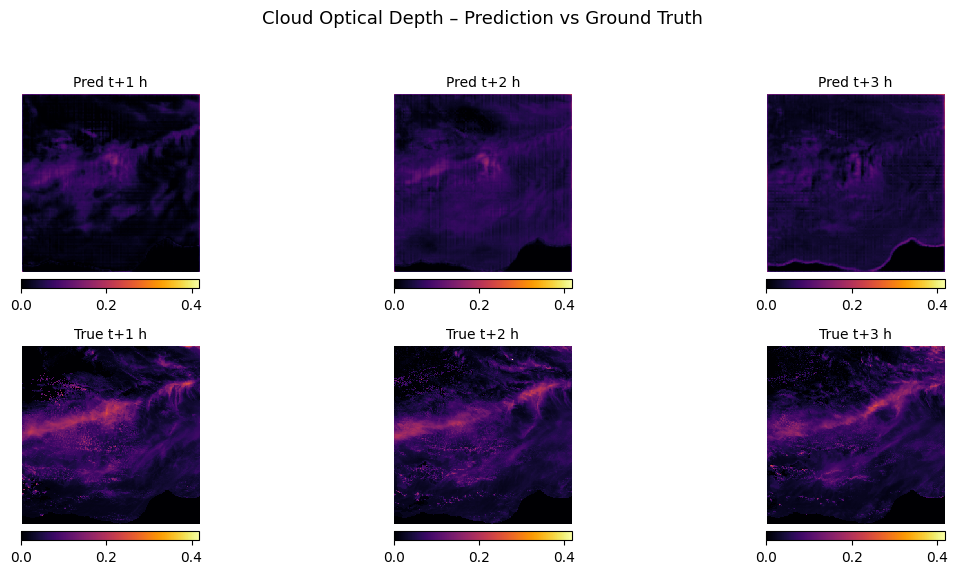

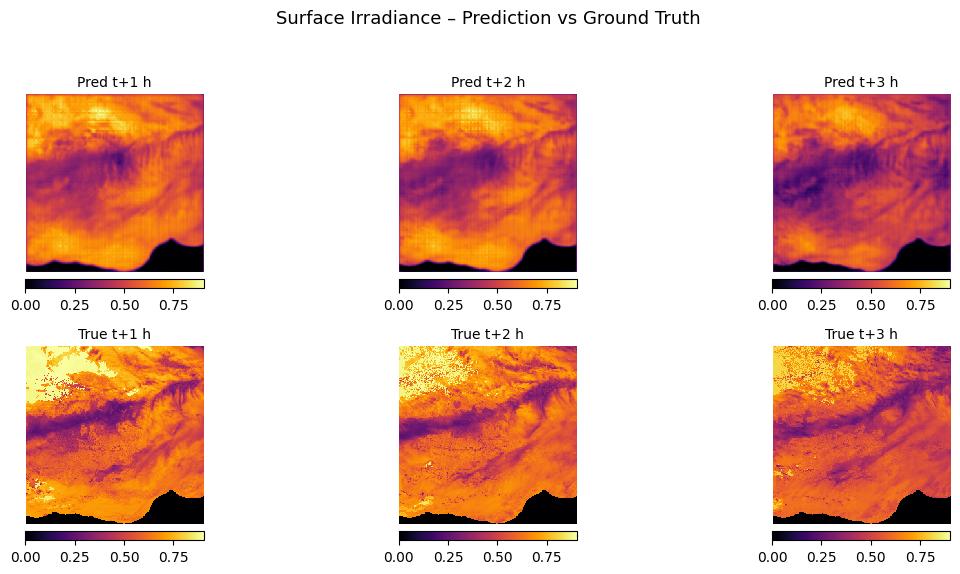

In [66]:
# Inference mode
lit_model.eval()
model = lit_model.model

t = Petdt(datetime.datetime(2024, 2, 2, 2, 0))
inputs, outputs = infer_pipe[t]

# Move to device
device = next(model.parameters()).device

# Convert to tensors (B, C, T, H, W)
x = torch.from_numpy(inputs).permute(1, 0, 2, 3).unsqueeze(0).float().to(device)
y_true = torch.from_numpy(outputs).permute(1, 0, 2, 3).unsqueeze(0).float().to(device)

# Replace NaNs and infs with 0
x = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
y_true = torch.nan_to_num(y_true, nan=0.0, posinf=0.0, neginf=0.0)

# Forward pass
with torch.no_grad():
    y_pred = model(x)
    y_pred = y_pred.squeeze(0).cpu().numpy()
    y_true = y_true.squeeze(0).cpu().numpy()

# Plot results
n_channels, n_pred_times = y_pred.shape[:2]
n_true_times = y_true.shape[1]
n_times = min(n_pred_times, n_true_times)
forecast_hours = [1, 2, 3][:n_times]
var_names = ["Cloud Optical Depth", "Surface Irradiance"]

for ch in range(n_channels):
    plt.figure(figsize=(12, 6))
    plt.suptitle(f"{var_names[ch]} – Prediction vs Ground Truth", fontsize=13)

    vmin = np.nanmin(y_true[ch])
    vmax = np.nanmax(y_true[ch])

    for t_idx in range(n_times):
        plt.subplot(2, n_times, t_idx + 1)
        im_pred = plt.imshow(
            y_pred[ch, t_idx],
            cmap="inferno",
            interpolation="none",
            vmin=vmin,
            vmax=vmax
        )
        plt.title(f"Pred t+{forecast_hours[t_idx]} h", fontsize=10)
        plt.axis("off")
        plt.colorbar(im_pred, fraction=0.046, pad=0.04, orientation="horizontal")

        plt.subplot(2, n_times, n_times + t_idx + 1)
        im_true = plt.imshow(
            y_true[ch, t_idx],
            cmap="inferno",
            interpolation="none",
            vmin=vmin,
            vmax=vmax
        )
        plt.title(f"True t+{forecast_hours[t_idx]} h", fontsize=10)
        plt.axis("off")
        plt.colorbar(im_true, fraction=0.046, pad=0.04, orientation="horizontal")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Evaluation metrics on the test set

In [67]:
ssi_metric = torchmetrics.image.StructuralSimilarityIndexMeasure()
rmse_sw_metric = torchmetrics.image.RootMeanSquaredErrorUsingSlidingWindow()

In [68]:
lit_model.eval()
model = lit_model.model  # actual UNet3D

ssi_values = []
rmse_values = []

test_iterator = iter(infer_pipe)

with torch.no_grad():
    for i in range(10):  # number of test instances
        inputs, outputs = next(test_iterator)

        device = next(model.parameters()).device

        x = torch.from_numpy(inputs).permute(1, 0, 2, 3).unsqueeze(0).float().to(device)
        y_true = torch.from_numpy(outputs).permute(1, 0, 2, 3).unsqueeze(0).float().to(device)

        # replace NaNs and infinities
        x = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
        y_true = torch.nan_to_num(y_true, nan=0.0, posinf=0.0, neginf=0.0)

        # forward pass
        y_pred = model(x)

        # move to CPU
        y_pred_cpu = y_pred.squeeze(0).cpu()
        y_true_cpu = y_true.squeeze(0).cpu()

        # compute metrics
        ssi = float(ssi_metric(y_true_cpu, y_pred_cpu))
        rmse = float(rmse_sw_metric(y_true_cpu, y_pred_cpu))

        ssi_values.append(ssi)
        rmse_values.append(rmse)

print("Mean SSI:", np.mean(ssi_values))
print("Mean RMSE:", np.mean(rmse_values))

Mean SSI: 0.6518143326044082
Mean RMSE: 0.1019033744931221


# Diurnal analysis - Model vs Persistence

In [69]:
lit_model.eval()
model = lit_model.model

tod_bins = {
    0: (0, 6),
    1: (6, 12),
    2: (12, 18),
    3: (18, 24)
}

ssi_bins = {i: [] for i in tod_bins}
rmse_bins = {i: [] for i in tod_bins}

ssi_pers_bins = {i: [] for i in tod_bins}
rmse_pers_bins = {i: [] for i in tod_bins}

timestamp_iter = iter(infer_pipe.iterator)
max_samples = 500
collected = 0

with torch.no_grad():
    while collected < max_samples:
        try:
            t = next(timestamp_iter)
        except StopIteration:
            break

        try:
            inputs, outputs = infer_pipe[t]
        except Exception:
            continue

        hour = t.datetime.hour
        if   0 <= hour < 6:   bin_id = 0
        elif 6 <= hour < 12:  bin_id = 1
        elif 12 <= hour < 18: bin_id = 2
        else:                 bin_id = 3

        device = next(model.parameters()).device

        x = torch.from_numpy(inputs).permute(1,0,2,3).unsqueeze(0).float().to(device)
        y_true = torch.from_numpy(outputs).permute(1,0,2,3).unsqueeze(0).float().to(device)

        x = torch.nan_to_num(x)
        y_true = torch.nan_to_num(y_true)

        # model prediction
        y_pred = model(x)

        # persistence prediction
        last_input = x[:, :, -1, :, :]  # (B, C, H, W)
        n_out = y_pred.shape[2]          # number of predicted timesteps
        pers = last_input.unsqueeze(2).repeat(1, 1, n_out, 1, 1)  # match shape

        y_pred_cpu = y_pred.squeeze(0).cpu()
        y_true_cpu = y_true.squeeze(0).cpu()
        pers_cpu = pers.squeeze(0).cpu()

        # model skill
        ssi_m = float(ssi_metric(y_true_cpu, y_pred_cpu))
        rmse_m = float(rmse_sw_metric(y_true_cpu, y_pred_cpu))

        # persistence skill
        ssi_p = float(ssi_metric(y_true_cpu, pers_cpu))
        rmse_p = float(rmse_sw_metric(y_true_cpu, pers_cpu))

        ssi_bins[bin_id].append(ssi_m)
        rmse_bins[bin_id].append(rmse_m)

        ssi_pers_bins[bin_id].append(ssi_p)
        rmse_pers_bins[bin_id].append(rmse_p)

        collected += 1

print("Collected:", collected)

Collected: 500


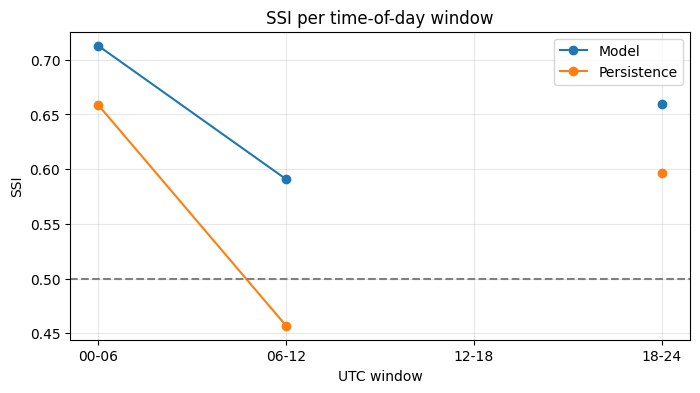

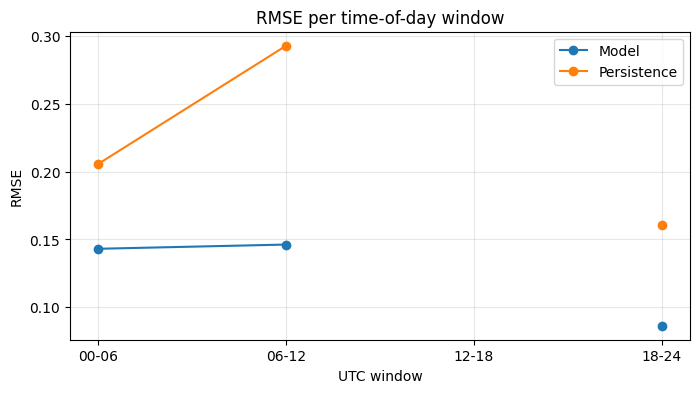

In [70]:
centres = [ (a+b)/2 for (a,b) in tod_bins.values() ]
labels = [f"{a:02d}-{b:02d}" for a,b in tod_bins.values()]

ssi_mean_m = [ np.mean(ssi_bins[i]) if len(ssi_bins[i])>0 else np.nan for i in tod_bins ]
ssi_mean_p = [ np.mean(ssi_pers_bins[i]) if len(ssi_pers_bins[i])>0 else np.nan for i in tod_bins ]

rmse_mean_m = [ np.mean(rmse_bins[i]) if len(rmse_bins[i])>0 else np.nan for i in tod_bins ]
rmse_mean_p = [ np.mean(rmse_pers_bins[i]) if len(rmse_pers_bins[i])>0 else np.nan for i in tod_bins ]

# SSI plot
plt.figure(figsize=(8,4))
plt.plot(centres, ssi_mean_m, marker="o", label="Model")
plt.plot(centres, ssi_mean_p, marker="o", label="Persistence")
plt.axhline(0.5, color="grey", linestyle="--")
plt.xticks(centres, labels)
plt.xlabel("UTC window")
plt.ylabel("SSI")
plt.title("SSI per time-of-day window")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# RMSE plot
plt.figure(figsize=(8,4))
plt.plot(centres, rmse_mean_m, marker="o", label="Model")
plt.plot(centres, rmse_mean_p, marker="o", label="Persistence")
plt.xticks(centres, labels)
plt.xlabel("UTC window")
plt.ylabel("RMSE")
plt.title("RMSE per time-of-day window")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Next steps

- Investigate whether the model handles cloud initiation and dissipation realistically.

- Check for systematic biases, especially in irradiance magnitude or optical depth over land–sea boundaries.